In [1]:
using Flux
using Flux: onehotbatch, @epochs, onecold, update!
using MLDatasets
using Plots
using CUDA
using PyPlot: matshow
using Statistics
using Distributions
using BSON: @save, @load
using Printf
using FileIO
CUDA.allowscalar(false)

In [2]:
train_x, train_y = MNIST.traindata()
test_x, test_y = MNIST.testdata()

#matshow(train_x[:,:,1]')

train_x = flatten(train_x) |> gpu
test_x = flatten(test_x) |> gpu

train_y = onehotbatch(train_y, 0:9) |> gpu
test_y = onehotbatch(test_y, 0:9) |> gpu

#train_data = [train_x, train_y] |> gpu
#test_data = [test_x, test_y] |> gpu

train_data = Flux.Data.DataLoader(train_x, train_y, batchsize=16, shuffle=true) |> gpu;

In [8]:
size(train_x)

(784, 60000)

In [3]:
function custom_train!(model, X, Y, loss, opt; epochs=10, val_X = [], val_Y = [], batchsize = 16, shuffle=true)
    ps = Flux.params(model)
    dl = Flux.Data.DataLoader(X, Y, batchsize=batchsize, shuffle=shuffle) |> gpu
    history = Dict("acc"=>[], "loss"=>[], "val_acc"=>[], "val_loss"=>[])
    acc(x,y) = mean(onecold(cpu(model(x))) .== onecold(cpu(y)))
    for e in 1:epochs
        print("\nEpoch "*string(e)*"/"*string(epochs)*": ")
        for d in dl
            x = d[1]
            y = d[2]
            gs = gradient(ps) do
                loss(x, y)
            end
            update!(opt, ps, gs)
        end
        a = acc(X, Y)
        l = loss(X, Y)
        @printf("acc: %.4f - loss: %.4f", a, l)
        push!(history["acc"], a)
        push!(history["loss"], l)
        if length(val_X) > 0 && length(val_Y) > 0
            val_a = acc(val_X, val_Y)
            val_l = loss(val_X, val_Y)
            @printf(" - val_acc: %.4f - val_loss: %.4f", val_a, val_l)
            push!(history["val_acc"], val_a)
            push!(history["val_loss"], val_l)
        end
    end
    history
end

custom_train! (generic function with 1 method)

In [4]:
model = Chain(
    Dense(28*28, 100, relu),
    Dense(100, 100, relu),
    Dense(100, 10),
    softmax
) |> gpu

loss(x, y) = Flux.crossentropy(model(x), y)
ps = Flux.params(model)
opt = ADAM()
acc(model,x,y) = mean(onecold(cpu(model(x))) .== onecold(cpu(y)))
function plot_acc(train_x, train_y, test_x, test_y)
    
end;

In [17]:
history = custom_train!(model, train_x, train_y, loss, opt, epochs=10, val_X=test_x, val_Y=test_y, batchsize=16);


Epoch 1/10: acc: 0.9706 - loss: 0.0992 - val_acc: 0.9663 - val_loss: 0.1109
Epoch 2/10: acc: 0.9813 - loss: 0.0630 - val_acc: 0.9723 - val_loss: 0.0923
Epoch 3/10: acc: 0.9859 - loss: 0.0435 - val_acc: 0.9740 - val_loss: 0.0828
Epoch 4/10: acc: 0.9877 - loss: 0.0376 - val_acc: 0.9749 - val_loss: 0.0866
Epoch 5/10: acc: 0.9878 - loss: 0.0365 - val_acc: 0.9738 - val_loss: 0.0991
Epoch 6/10: acc: 0.9893 - loss: 0.0315 - val_acc: 0.9767 - val_loss: 0.0851
Epoch 7/10: acc: 0.9905 - loss: 0.0282 - val_acc: 0.9751 - val_loss: 0.0979
Epoch 8/10: acc: 0.9920 - loss: 0.0232 - val_acc: 0.9766 - val_loss: 0.0891
Epoch 9/10: acc: 0.9912 - loss: 0.0267 - val_acc: 0.9773 - val_loss: 0.0982
Epoch 10/10: acc: 0.9918 - loss: 0.0262 - val_acc: 0.9764 - val_loss: 0.1095

In [6]:
@save "MNIST_models/baseline.BSON" model

In [5]:
@load "MNIST_models/model.BSON" model
model = gpu(model)

Chain(Dense(784, 100, relu), Dense(100, 100, relu), Dense(100, 10), softmax)

In [4]:
#@epochs 15 Flux.train!(loss, ps, train_data, opt, cb = Flux.throttle(() -> @show(acc(model, test_x, test_y)), 10))

┌ Info: Epoch 1
└ @ Main C:\Users\Philip\.julia\packages\Flux\goUGu\src\optimise\train.jl:136


acc(model, test_x, test_y) = 0.1199
acc(model, test_x, test_y) = 0.9608


┌ Info: Epoch 2
└ @ Main C:\Users\Philip\.julia\packages\Flux\goUGu\src\optimise\train.jl:136


acc(model, test_x, test_y) = 0.9647


┌ Info: Epoch 3
└ @ Main C:\Users\Philip\.julia\packages\Flux\goUGu\src\optimise\train.jl:136


acc(model, test_x, test_y) = 0.9709


┌ Info: Epoch 4
└ @ Main C:\Users\Philip\.julia\packages\Flux\goUGu\src\optimise\train.jl:136


acc(model, test_x, test_y) = 0.9771


┌ Info: Epoch 5
└ @ Main C:\Users\Philip\.julia\packages\Flux\goUGu\src\optimise\train.jl:136


acc(model, test_x, test_y) = 0.9718


┌ Info: Epoch 6
└ @ Main C:\Users\Philip\.julia\packages\Flux\goUGu\src\optimise\train.jl:136
┌ Info: Epoch 7
└ @ Main C:\Users\Philip\.julia\packages\Flux\goUGu\src\optimise\train.jl:136


acc(model, test_x, test_y) = 0.9755
acc(model, test_x, test_y) = 0.9753


┌ Info: Epoch 8
└ @ Main C:\Users\Philip\.julia\packages\Flux\goUGu\src\optimise\train.jl:136


acc(model, test_x, test_y) = 0.9763


┌ Info: Epoch 9
└ @ Main C:\Users\Philip\.julia\packages\Flux\goUGu\src\optimise\train.jl:136


acc(model, test_x, test_y) = 0.9768


┌ Info: Epoch 10
└ @ Main C:\Users\Philip\.julia\packages\Flux\goUGu\src\optimise\train.jl:136


acc(model, test_x, test_y) = 0.9769


┌ Info: Epoch 11
└ @ Main C:\Users\Philip\.julia\packages\Flux\goUGu\src\optimise\train.jl:136


acc(model, test_x, test_y) = 0.972


┌ Info: Epoch 12
└ @ Main C:\Users\Philip\.julia\packages\Flux\goUGu\src\optimise\train.jl:136


acc(model, test_x, test_y) = 0.9773


┌ Info: Epoch 13
└ @ Main C:\Users\Philip\.julia\packages\Flux\goUGu\src\optimise\train.jl:136


acc(model, test_x, test_y) = 0.9769


┌ Info: Epoch 14
└ @ Main C:\Users\Philip\.julia\packages\Flux\goUGu\src\optimise\train.jl:136


acc(model, test_x, test_y) = 0.9768


┌ Info: Epoch 15
└ @ Main C:\Users\Philip\.julia\packages\Flux\goUGu\src\optimise\train.jl:136


In [7]:
acc(model, test_x, test_y)

0.9737

In [6]:
function pgd(loss, x0, y; ϵ=0.1, steps=10)
    α = 2.5*ϵ/steps
    #x = cpu(x)
    x = copy(x0)
    for k in 1:steps
        grad = gradient(Flux.params(x)) do
            loss(x, y)
        end
        x = x + α*sign.(grad[x])
        x = clamp.(x, x0.-ϵ, x0.+ϵ)
        x = clamp.(x, 0.0, 1.0)
        x = typeof(x0)(x)
    end
    x
end

pgd (generic function with 1 method)

In [15]:
e = 0.35
pgd_test_x = pgd(loss, test_x, test_y, ϵ=e, steps=10)
println("PGD: "*string(acc(model, pgd_test_x, test_y)))
randvec = rand(Normal(0, e), size(test_x)) |> gpu
WN_test_x = test_x + randvec
println("WN: "*string(acc(model, WN_test_x, test_y)))

LoadError: ArgumentError: FixedPointNumbers.Normed{UInt8,8} is an 8-bit type representing 256 values from 0.0 to 1.0; cannot represent NaN

In [7]:
function twiny(sp::Plots.Subplot)
    sp[:top_margin] = max(sp[:top_margin], 30Plots.px)
    plot!(sp.plt, inset = (sp[:subplot_index], bbox(0,0,1,1)))
    twinsp = sp.plt.subplots[end]
    twinsp[:xaxis][:mirror] = true
    twinsp[:background_color_inside] = RGBA{Float64}(0,0,0,0)
    Plots.link_axes!(sp[:yaxis], twinsp[:yaxis])
    twinsp
end
twiny(plt::Plots.Plot = current()) = twiny(plt[1])

twiny (generic function with 3 methods)

In [13]:
pgd_accs = []
WN_accs = []
es = 0:0.005:0.1
for e in es
    pgd_test_x = pgd(loss, test_x, test_y, ϵ=2*e, steps=10)
    randvec = rand(Normal(0, e), size(test_x)) |> gpu
    WN_test_x = test_x + randvec
    WN_test_x = clamp.(WN_test_x, 0, 1)
    push!(pgd_accs, acc(model, pgd_test_x, test_y))
    push!(WN_accs, acc(model, WN_test_x, test_y))
end

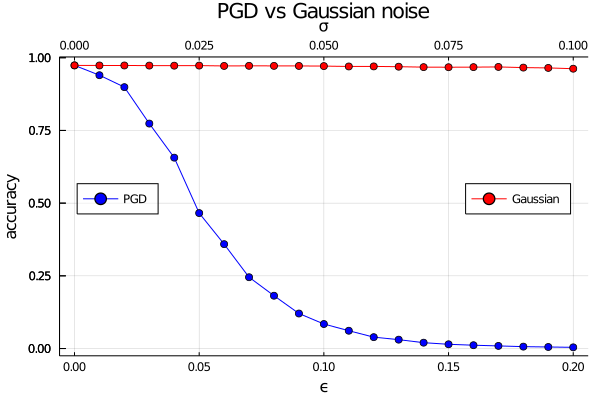

In [14]:
pp = plot(2*es, pgd_accs, xlabel="ϵ", ylabel="accuracy", marker=:circle, color=:blue, label="PGD", 
    legend=:left, title="PGD vs Gaussian noise")
p = twiny()
plot!(p, es, WN_accs, xlabel="σ", marker=:circle, color=:red, label="Gaussian", legend=:right)

In [15]:
savefig(pp, "figures/pgdvsgaussian.svg")

In [19]:
function pgd_train!(loss, ps, data, opt; ϵ=0.1, cb = () -> ())
    local training_loss
    for d in data
        x = pgd(loss, d[1], d[2], ϵ=ϵ)
        gs = gradient(ps) do
            training_loss = loss(x, d[2])
            training_loss
        end
        update!(opt, ps, gs)
        cb()
    end
end

pgd_train! (generic function with 1 method)

In [16]:
function pgd_train!(model, X, Y, loss, opt; epochs=10, val_X = [], val_Y = [], batchsize = 16, shuffle=true, ϵ=0.1)
    ps = Flux.params(model)
    dl = Flux.Data.DataLoader(X, Y, batchsize=batchsize, shuffle=shuffle) |> gpu
    history = Dict("acc"=>[], "loss"=>[], "val_acc"=>[], "val_loss"=>[])
    acc(x,y) = mean(onecold(cpu(model(x))) .== onecold(cpu(y)))
    for e in 1:epochs
        print("\nEpoch "*string(e)*"/"*string(epochs)*": ")
        for d in dl
            x = pgd(loss, d[1], d[2], ϵ=ϵ)
            y = d[2]
            gs = gradient(ps) do
                loss(x, y)
            end
            update!(opt, ps, gs)
        end
        pgd_X = pgd(loss, X, Y, ϵ=ϵ)
        a = acc(X, Y)
        l = loss(X, Y)
        @printf("acc: %.4f - loss: %.4f", a, l)
        push!(history["acc"], a)
        push!(history["loss"], l)
        if length(val_X) > 0 && length(val_Y) > 0
            pgd_val_X = pgd(loss, val_X, val_Y, ϵ=ϵ)
            val_a = acc(val_X, val_Y)
            val_l = loss(val_X, val_Y)
            @printf(" - val_acc: %.4f - val_loss: %.4f", val_a, val_l)
            push!(history["val_acc"], val_a)
            push!(history["val_loss"], val_l)
        end
    end
    history
end

pgd_train! (generic function with 1 method)

In [27]:
pgd_model = Chain(
    Dense(28*28, 100, relu),
    Dense(100, 100, relu),
    Dense(100, 10),
    softmax
) |> gpu
Flux.loadparams!(pgd_model, Flux.params(model))

pgd_loss(x, y) = Flux.crossentropy(pgd_model(x), y)
ps = Flux.params(pgd_model)
opt = ADAM()
function pgd_acc(x, y; ϵ=0.1)
    pgd_x = pgd(pgd_loss, x, y, ϵ=ϵ)
    mean(onecold(cpu(pgd_model(pgd_x))) .== onecold(cpu(y)))
end

pgd_acc (generic function with 1 method)

In [28]:
history = pgd_train!(pgd_model, train_x, train_y, pgd_loss, opt, epochs=10, val_X=test_x, val_Y=test_y, batchsize=16, ϵ=0.15);


Epoch 1/10: 

LoadError: ArgumentError: FixedPointNumbers.Normed{UInt8,8} is an 8-bit type representing 256 values from 0.0 to 1.0; cannot represent NaN

In [16]:
pgd_model = cpu(pgd_model)
@save "MNIST_models/01_pgd_model02.BSON" pgd_model

In [25]:
for ϵ in 0.15:0.05:0.5
    @load "MNIST_models/model.BSON" model
    pgd_model = gpu(model)
    history = pgd_train!(pgd_model, train_x, train_y, pgd_loss, opt, epochs=10, val_X=test_x, val_Y=test_y, batchsize=16, ϵ=ϵ)
    model_name = "MNIST_models/"*replace.(string(ϵ), "." => "")*"_pgd_model.BSON"
    pgd_model = cpu(pgd_model)
    @save model_name pgd_model
end


Epoch 1/10: acc: 0.9271 - loss: 0.3061 - val_acc: 0.9305 - val_loss: 0.2963
Epoch 2/10: acc: 0.9409 - loss: 0.2293 - val_acc: 0.9443 - val_loss: 0.2207
Epoch 3/10: acc: 0.9535 - loss: 0.1808 - val_acc: 0.9550 - val_loss: 0.1742
Epoch 4/10: acc: 0.9562 - loss: 0.1676 - val_acc: 0.9574 - val_loss: 0.1626
Epoch 5/10: acc: 0.9548 - loss: 0.1688 - val_acc: 0.9565 - val_loss: 0.1644
Epoch 6/10: acc: 0.9554 - loss: 0.1629 - val_acc: 0.9579 - val_loss: 0.1589
Epoch 7/10: acc: 0.9586 - loss: 0.1454 - val_acc: 0.9590 - val_loss: 0.1430
Epoch 8/10: acc: 0.9605 - loss: 0.1402 - val_acc: 0.9598 - val_loss: 0.1393
Epoch 9/10: acc: 0.9604 - loss: 0.1364 - val_acc: 0.9607 - val_loss: 0.1342
Epoch 10/10: acc: 0.9626 - loss: 0.1309 - val_acc: 0.9614 - val_loss: 0.1311
Epoch 1/10: 

LoadError: ArgumentError: FixedPointNumbers.N0f8 is an 8-bit type representing 256 values from 0.0 to 1.0; cannot represent NaN

In [22]:
string(0.05)
#@epochs 15 pgd_train!(pgd_loss, ps, train_data, opt, ϵ=0.1, cb = Flux.throttle(() -> @show(pgd_acc(test_x, test_y, ϵ=0.1)), 10))

"0.05"

In [87]:
e = 2
println("0: "*string(acc(pgd_model, test_x, test_y)))
# pgd_test_x = pgd(pgd_loss, test_x, test_y, ϵ=e)
# println("PGD: "*string(acc(pgd_model, pgd_test_x, test_y)))
randvec = rand(Normal(0, e), size(test_x)) |> gpu
WN_test_x = test_x + randvec
println("WN: "*string(acc(pgd_model, WN_test_x, test_y)))

0: 0.9838
WN: 0.3758


In [30]:
println("0: "*string(acc(model, test_x, test_y)))
# pgd_test_x = pgd(loss, test_x, test_y, ϵ=e)
# println("PGD: "*string(acc(model, pgd_test_x, test_y)))
randvec = rand(Normal(0, e), size(test_x)) |> gpu
WN_test_x = test_x + randvec
println("WN: "*string(acc(model, WN_test_x, test_y)))

0: 0.9737
WN: 0.5005


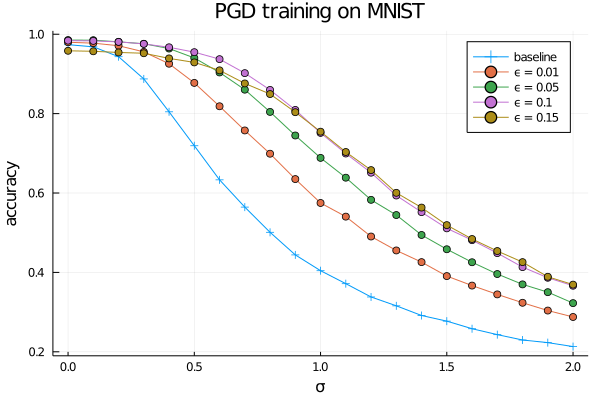

In [10]:
σs = 0.0:0.1:2.0
ϵs = (0.01, 0.05, 0.1, 0.15)
total_pgd_WN_results = []
for ϵ in ϵs
    model_name = "MNIST_models/"*replace.(string(ϵ), "." => "")*"_pgd_model.BSON"
    @load model_name pgd_model
    pgd_model = gpu(pgd_model)
    pgd_WN_results = []
    for σ in σs
        randvec = rand(Normal(0, σ), size(test_x)) |> gpu
        WN_test_x = test_x + randvec
        push!(pgd_WN_results, acc(pgd_model, WN_test_x, test_y))
    end
    push!(total_pgd_WN_results, pgd_WN_results)
end

base_WN_results = []
for σ in σs
    randvec = rand(Normal(0, σ), size(test_x)) |> gpu
    WN_test_x = test_x + randvec
    push!(base_WN_results, acc(model, WN_test_x, test_y))
end

p1 = plot()
plot!(p1, σs, base_WN_results, marker=:+, label = "baseline", xlabel="σ", ylabel="accuracy", title="PGD training on MNIST")

for (ϵ, res) in zip(ϵs, total_pgd_WN_results)
    plot!(p1, σs, res, marker=:circle, label = "ϵ = "*string(ϵ))
end
display(p1)

In [12]:
savefig(p1, "figures/mnist_acc.svg")

In [12]:
mean.(total_pgd_WN_results)
mean(base_WN_results)

0.5049952380952382

In [34]:
model = cpu(model)
pgd_model = cpu(pgd_model)
@save "MNIST_models/model.BSON" model
@save "MNIST_models/01_pgd_model.BSON" pgd_model
model = gpu(model)
pgd_model = gpu(pgd_model)

Chain(Dense(784, 100, relu), Dense(100, 100, relu), Dense(100, 10), softmax)

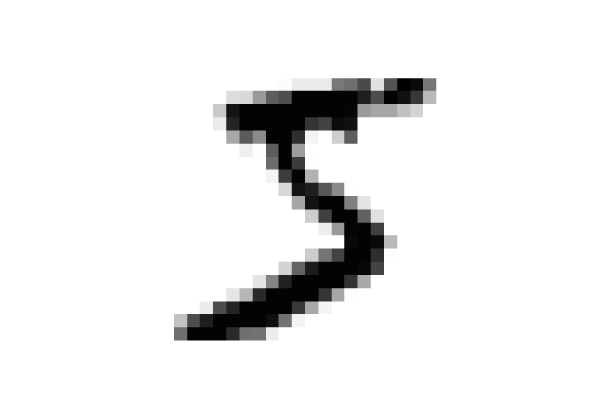

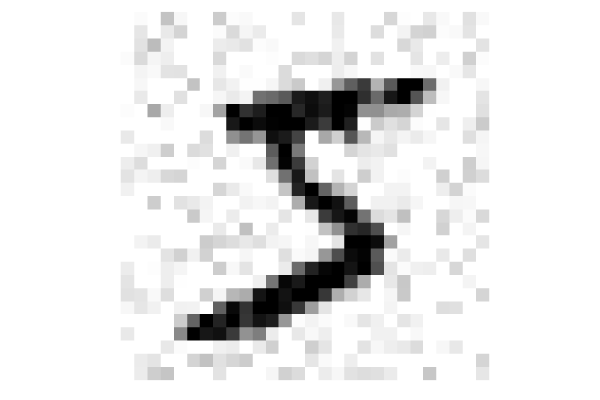

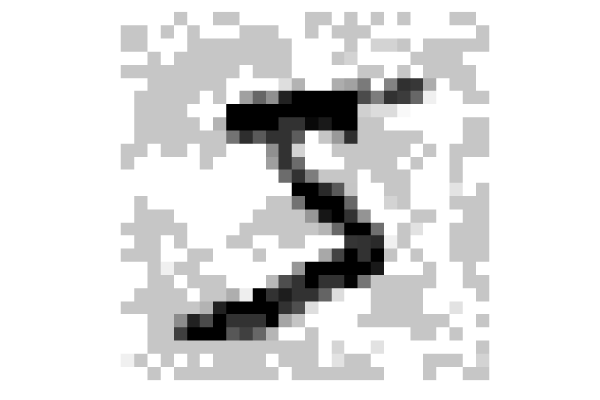

normal: 5
WN: 5
PGD: 3


In [32]:
n = 1
vis_x, vis_y = MNIST.traindata()
normal_fig = heatmap(vis_x[:,:,n]', yflip=true, aspect_ratio=1, axis=nothing, showaxis=false,
    legend=nothing, c=:grayC, background=nothing)
display(normal_fig)
r_vis_x = vis_x + rand(Normal(0, 0.1), size(vis_x))
r_vis_x = clamp.(r_vis_x, 0, 1)
#noise_fig = matshow(r_vis_x[:,:,n]')
noise_fig = heatmap(r_vis_x[:,:,n]', yflip=true, aspect_ratio=1, axis=nothing, showaxis=false,
    legend=nothing, c=:grayC, background_color = :transparent)
display(noise_fig)
c_model = pgd_model |> cpu
c_loss(x, y) = Flux.crossentropy(c_model(x), y)
gpu_x = flatten(vis_x)
gpu_y = onehotbatch(vis_y, 0:9)
pgd_vis_x = pgd(c_loss, gpu_x[:,n], gpu_y[:,n], ϵ=0.2)
pgd_vis_x = reshape(pgd_vis_x, (28, 28, 1))
#pgd_fig = matshow(pgd_vis_x[:,:, 1]')
pgd_fig = heatmap(pgd_vis_x[:,:,n]', yflip=true, aspect_ratio=1, axis=nothing, showaxis=false,
    legend=nothing, c=:grayC, background=nothing)
display(pgd_fig)
pred_n = onecold(c_model(flatten(vis_x)))[n] - 1
pred_wn = onecold(c_model(flatten(r_vis_x)))[n] - 1
pred_pgd = onecold(c_model(flatten(pgd_vis_x)))[n] - 1
println("normal: "*string(pred_n)*"\nWN: "*string(pred_wn)*"\nPGD: "*string(pred_pgd))

In [34]:
savefig(normal_fig, "figures/normal_5.png")
savefig(noise_fig, "figures/noise_5.png")
savefig(pgd_fig, "figures/pgd_5.png")